In [1]:
import pandas as pd
import matplotlib.pyplot as pl
from keras.preprocessing.text import one_hot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)




Using TensorFlow backend.


In [2]:
df_main=pd.read_json('train-v2.0.json')

In [3]:
df_main.head()

,version,data
0,v2.0,"{'title': 'Beyoncé', 'paragraphs': [{'qas': [{..."
1,v2.0,"{'title': 'Frédéric_Chopin', 'paragraphs': [{'..."
2,v2.0,{'title': 'Sino-Tibetan_relations_during_the_M...
3,v2.0,"{'title': 'IPod', 'paragraphs': [{'qas': [{'qu..."
4,v2.0,{'title': 'The_Legend_of_Zelda:_Twilight_Princ...


In [4]:
df_main.shape

(442, 2)

In [5]:
temp=df_main['data'][0]

In [6]:
par=temp['paragraphs']

In [7]:
ques=par[0]['qas']
ques[0]

{'question': 'When did Beyonce start becoming popular?',
 'id': '56be85543aeaaa14008c9063',
 'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
 'is_impossible': False}

In [8]:
title=[]
questions=[]
answers=[]
answer_start=[]
is_answerable=[]

In [9]:
for sample in df_main['data']:
    pars=sample['paragraphs']
    for par in pars:
        ques=par['qas']
        for i in ques:
            questions.append(i['question'])
            if i['answers']:
                answers.append(i['answers'][0]['text'])
                answer_start.append(i['answers'][0]['answer_start'])
            else:
                answers.append('Null')
                answer_start.append('Null')
            is_answerable.append(i['is_impossible'])

In [10]:
len(questions),len(answers),len(answer_start),len(is_answerable)

(130319, 130319, 130319, 130319)

In [11]:
df=pd.DataFrame({'Question':questions,
                 'Answers':answers,
                 'Answer_start':answer_start,
                 'Is_answerable':is_answerable
                })

In [12]:
df.head(10)

,Question,Answers,Answer_start,Is_answerable
0,When did Beyonce start becoming popular?,in the late 1990s,269,False
1,What areas did Beyonce compete in when she was...,singing and dancing,207,False
2,When did Beyonce leave Destiny's Child and bec...,2003,526,False
3,In what city and state did Beyonce grow up?,"Houston, Texas",166,False
4,In which decade did Beyonce become famous?,late 1990s,276,False
5,In what R&B group was she the lead singer?,Destiny's Child,320,False
6,What album made her a worldwide known artist?,Dangerously in Love,505,False
7,Who managed the Destiny's Child group?,Mathew Knowles,360,False
8,When did Beyoncé rise to fame?,late 1990s,276,False
9,What role did Beyoncé have in Destiny's Child?,lead singer,290,False


In [13]:
dev_data=pd.read_json('dev-v2.0.json')

In [14]:
questions=[]
answers=[]
answer_start=[]
is_answerable=[]
for sample in dev_data['data']:
    pars=sample['paragraphs']
    for par in pars:
        ques=par['qas']
        for i in ques:
            questions.append(i['question'])
            if i['answers']:
                answers.append(i['answers'][0]['text'])
                answer_start.append(i['answers'][0]['answer_start'])
            else:
                answers.append('Null')
                answer_start.append('Null')
            is_answerable.append(i['is_impossible'])
dev_df=pd.DataFrame({'Question':questions,
                 'Answers':answers,
                 'Answer_start':answer_start,
                 'Is_answerable':is_answerable
                })

In [15]:
dev_df

,Question,Answers,Answer_start,Is_answerable
0,In what country is Normandy located?,France,159,False
1,When were the Normans in Normandy?,10th and 11th centuries,94,False
2,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256,False
3,Who was the Norse leader?,Rollo,308,False
4,What century did the Normans first gain their ...,10th century,671,False
...,...,...,...,...
11868,What is the seldom used force unit equal to on...,sthène,665,False
11869,What does not have a metric counterpart?,Null,Null,True
11870,What is the force exerted by standard gravity ...,Null,Null,True
11871,What force leads to a commonly used unit of mass?,Null,Null,True


<IPython.core.display.Javascript object>

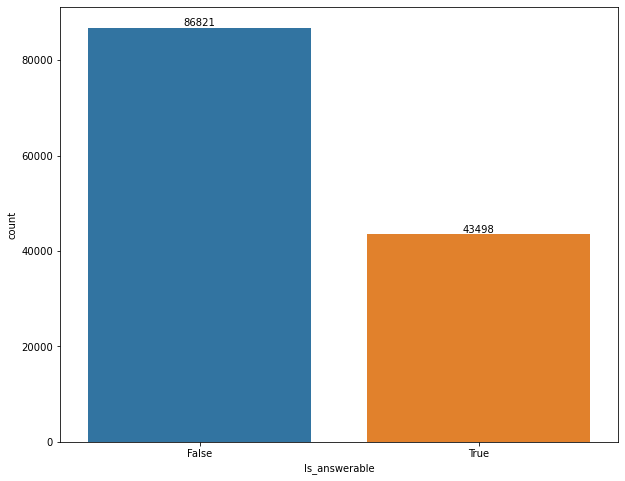

In [16]:
pl.figure(figsize=(10,8))

ax=sns.countplot(df['Is_answerable'])
rects=ax.patches

for rect in rects:
    height=rect.get_height()
    ax.text(x=rect.get_x()+rect.get_width()/2,y=height+5,s=height,ha='center',va='bottom')
pl.show()

<IPython.core.display.Javascript object>

-0.4 0.8
0.6 0.8


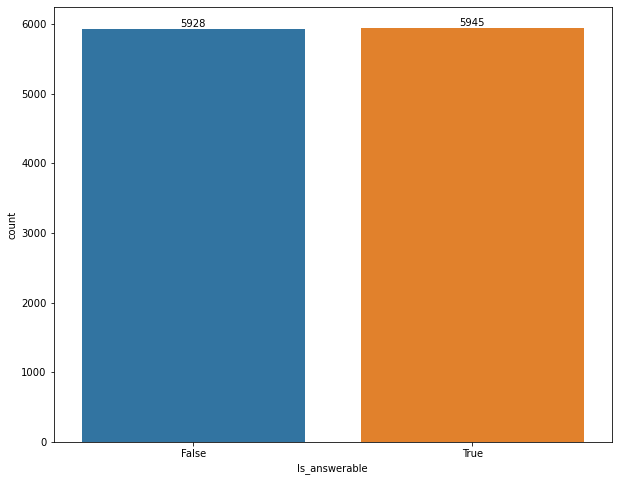

In [17]:
pl.figure(figsize=(10,8))

ax=sns.countplot(dev_df['Is_answerable'])
rects=ax.patches
for rect in rects:
    height=rect.get_height()
    print(rect.get_x(),rect.get_width())
    ax.text(x=rect.get_x()+rect.get_width()/2,y=height+1,s=height,ha='center',va='bottom')
pl.show()

In [18]:
len(df),df['Answer_start'].nunique()

(130319, 1604)

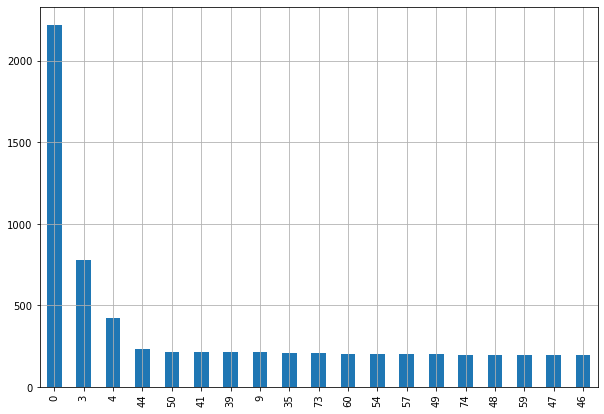

In [19]:
df['Answer_start'].value_counts()[1:20].plot(kind='bar',figsize=(10,7))
pl.grid()
pl.show()

In [20]:
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

In [21]:
df['len_que']=df['Question'].apply(lambda x: len(x))
df['len_ans']=df['Answers'].apply(lambda x: len(x))

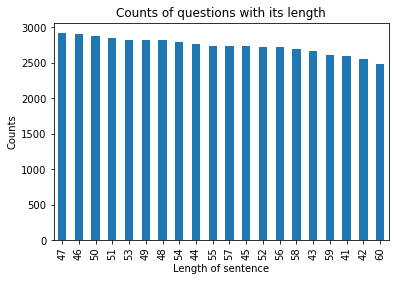

In [22]:
df['len_que'].value_counts()[:20].plot.bar()
pl.title('Counts of questions with its length')
pl.xlabel('Length of sentence')
pl.ylabel('Counts')
pl.show()

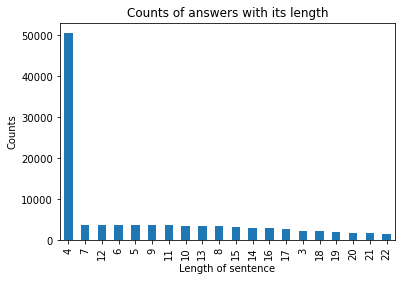

In [23]:
df['len_ans'].value_counts()[:20].plot.bar()
pl.title('Counts of answers with its length')
pl.xlabel('Length of sentence')
pl.ylabel('Counts')
pl.show()

In [24]:
df.describe()

,len_que,len_ans
count,130319.000000,130319.000000
mean,58.507739,14.758884
std,73.757111,19.193666
min,1.000000,1.000000
25%,44.000000,4.000000
50%,55.000000,7.000000
75%,69.000000,17.000000
max,25651.000000,239.000000


In [25]:
df.drop(107709,axis=0,inplace=True)

In [26]:
df.reset_index(drop=True,inplace=True)

In [27]:
df.head()

,Question,Answers,Answer_start,Is_answerable,len_que,len_ans
0,When did Beyonce start becoming popular?,in the late 1990s,269,False,40,17
1,What areas did Beyonce compete in when she was...,singing and dancing,207,False,58,19
2,When did Beyonce leave Destiny's Child and bec...,2003,526,False,64,4
3,In what city and state did Beyonce grow up?,"Houston, Texas",166,False,45,14
4,In which decade did Beyonce become famous?,late 1990s,276,False,42,10


In [28]:
len(df)

130318

In [29]:
df=df.sort_values('len_que',ascending=False)[5000:].copy()

In [30]:
df_s=df[df['Answers']!='Null'].copy()

In [31]:
df_s=df_s.sample(10000).copy()

In [41]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [42]:
for line,t in zip(df_s['Question'],df_s['Answers']):
    input_texts.append(line)
    t = '\t' + t + '\n'
    target_texts.append(t)
    for char in line:
        if char not in input_characters:
            input_characters.add(char)
    for char in t:
        if char not in target_characters:
            target_characters.add(char)


In [79]:
df_save=pd.DataFrame({'Input':input_texts,
                      'Output':target_texts})
df_save.to_csv('inout.csv')

In [78]:
target_texts

['\tbus stations\n',
 '\tjhāna\n',
 '\tJapan\n',
 '\tFile Transfer Protocol\n',
 '\tTimothy Rowe\n',
 '\tSeoul\n',
 '\tLake Paranoá\n',
 '\tAffirmative Action Around the World: An Empirical Study\n',
 '\t488 million[web 1] and 535 million\n',
 '\teggs or ova\n',
 '\t9.9 million\n',
 '\ta red penalty card\n',
 '\tThe Towers Square\n',
 '\tFirelight\n',
 '\tdetailed identification\n',
 '\tjuices stored in galvanized cans\n',
 '\t0.97% to 2%\n',
 '\tThe Bolsheviks\n',
 '\ttwo\n',
 '\t1929\n',
 '\tU.S. Ambassador to Canada\n',
 '\tstanding wave\n',
 '\tS. pyogenes\n',
 '\tKorea and Vietnam\n',
 '\t1867\n',
 '\tEdward\n',
 '\tmonarchy\n',
 '\tLos Angeles\n',
 '\tthe Holy Roman Empire\n',
 "\tDesigners' Way\n",
 '\tover 30,000\n',
 '\tThe 24-pin double-sided connector\n',
 '\tall times\n',
 '\tfull-time undergraduate\n',
 '\thydrogen\n',
 '\tblood plasma fractions\n',
 '\tHayy ibn Yaqdhan (Philosophus Autodidactus)\n',
 '\t1992\n',
 '\tfour-year terms,\n',
 '\tthe Hellenistic age\n',
 '\tRon

In [49]:
input_texts[10],target_texts[10]

('How many people watched the first episode of American Idol?',
 '\t9.9 million\n')

In [50]:
print(input_characters)

{'.', 'ū', 'w', '8', 'í', '"', 'ē', 'ê', 'E', 'N', 'L', 'x', 'ε', 'ν', '*', 'ὠ', 'ú', 'Ś', 'Q', 'f', '督', '2', '1', '9', 's', 'K', 'ü', 'ź', '>', 'o', ' ', 'ῖ', '7', 'é', 'α', 'z', 'u', 'g', 'κ', 'ç', '5', 'P', '6', 'ï', '-', 'b', 'U', 'R', 'H', 'ń', '!', '徒', 'c', ']', '(', 'Y', 'ρ', 'C', 'Χ', 'ī', 'd', 'q', '&', '?', 'j', ',', 'F', 'T', '+', 'δ', 'r', 'p', 'W', 'B', 'ó', 'O', '’', 'ι', '基', 'A', 'D', 'ǒ', 'a', 't', '%', ':', '3', '–', 'J', 'ě', 'y', ')', 'h', 'ß', 'ς', 'ö', 'ʰ', 'ō', 'm', 'τ', '4', 'ό', 'ā', 'ć', 'S', '0', 'V', 'X', 'e', '[', 'ἰ', 'l', 'ø', 'v', 'á', '$', '−', 'I', "'", 'n', 'ä', 'i', 'M', '/', 'σ', 'Ṣ', '→', 'Z', 'G', 'k'}


In [51]:
print(target_characters)

{'.', 'Ł', 'ū', 'w', '€', 'Š', '8', 'í', '"', 'ē', 'ė', 'Œ', 'ñ', 'Ż', 'E', 'N', 'L', 'έ', 'x', '♠', 'ν', 'ú', 'ş', 'š', 'ò', 'Q', '°', 'f', '2', '1', '9', 'ı', 's', 'K', 'ü', 'γ', '>', 'ṇ', 'o', ' ', 'Ć', '7', 'é', 'ô', 'z', 'u', 'с', 'ğ', 'g', 'ã', 'ç', '5', 'P', '6', 'ł', 'É', 'õ', '-', 'b', 'R', 'U', 'H', 'ń', '!', 'c', '—', ']', '(', 'Y', 'β', 'ṃ', 'ṣ', 'ء', 'C', 'è', 'ī', 'd', 'q', 'č', '&', 'F', 'j', ',', '?', 'T', '”', 'ž', 'â', 'r', 'p', 'ο', 'W', 'B', 'ó', 'O', '’', 'ņ', 'A', 'D', 'a', 't', 'ũ', '%', ':', '3', '–', 'J', 'y', ')', 'h', 'ß', 'ς', 'ö', 'ō', 'm', '‘', '4', 'ā', 'ć', 'S', '0', '#', '\n', 'ż', 'V', 'Ö', 'ấ', 'X', 'ễ', '£', 'e', '[', 'l', ';', 'v', 'à', 'á', '$', '−', 'I', 'ʼ', "'", 'n', '⁄', 'ä', '\t', 'i', 'M', '/', 'Æ', '̍', '“', 'Z', 'G', 'k'}


In [53]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])


print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 130
Number of unique output tokens: 155
Max sequence length for inputs: 100
Max sequence length for outputs: 183


In [54]:
input_token_index = dict(
  [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
  [(char, i) for i, char in enumerate(target_characters)])

In [299]:
print(input_token_index)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '*': 10, '+': 11, ',': 12, '-': 13, '.': 14, '/': 15, '0': 16, '1': 17, '2': 18, '3': 19, '4': 20, '5': 21, '6': 22, '7': 23, '8': 24, '9': 25, ':': 26, ';': 27, '=': 28, '>': 29, '?': 30, 'A': 31, 'B': 32, 'C': 33, 'D': 34, 'E': 35, 'F': 36, 'G': 37, 'H': 38, 'I': 39, 'J': 40, 'K': 41, 'L': 42, 'M': 43, 'N': 44, 'O': 45, 'P': 46, 'Q': 47, 'R': 48, 'S': 49, 'T': 50, 'U': 51, 'V': 52, 'W': 53, 'X': 54, 'Y': 55, 'Z': 56, '[': 57, ']': 58, 'a': 59, 'b': 60, 'c': 61, 'd': 62, 'e': 63, 'f': 64, 'g': 65, 'h': 66, 'i': 67, 'j': 68, 'k': 69, 'l': 70, 'm': 71, 'n': 72, 'o': 73, 'p': 74, 'q': 75, 'r': 76, 's': 77, 't': 78, 'u': 79, 'v': 80, 'w': 81, 'x': 82, 'y': 83, 'z': 84, '×': 85, 'Ü': 86, 'à': 87, 'á': 88, 'ä': 89, 'ç': 90, 'è': 91, 'é': 92, 'ê': 93, 'í': 94, 'ï': 95, 'ñ': 96, 'ó': 97, 'ö': 98, 'ü': 99, 'ā': 100, 'ć': 101, 'ē': 102, 'ě': 103, 'ī': 104, 'İ': 105, 'ł': 106, 'ń': 107, 'Ş': 108, 'š': 109, 'ū': 110,

In [300]:
print(target_token_index)

{'\t': 0, '\n': 1, ' ': 2, '!': 3, '"': 4, '#': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, '*': 12, '+': 13, ',': 14, '-': 15, '.': 16, '/': 17, '0': 18, '1': 19, '2': 20, '3': 21, '4': 22, '5': 23, '6': 24, '7': 25, '8': 26, '9': 27, ':': 28, ';': 29, '>': 30, '?': 31, 'A': 32, 'B': 33, 'C': 34, 'D': 35, 'E': 36, 'F': 37, 'G': 38, 'H': 39, 'I': 40, 'J': 41, 'K': 42, 'L': 43, 'M': 44, 'N': 45, 'O': 46, 'P': 47, 'Q': 48, 'R': 49, 'S': 50, 'T': 51, 'U': 52, 'V': 53, 'W': 54, 'X': 55, 'Y': 56, 'Z': 57, '[': 58, ']': 59, 'a': 60, 'b': 61, 'c': 62, 'd': 63, 'e': 64, 'f': 65, 'g': 66, 'h': 67, 'i': 68, 'j': 69, 'k': 70, 'l': 71, 'm': 72, 'n': 73, 'o': 74, 'p': 75, 'q': 76, 'r': 77, 's': 78, 't': 79, 'u': 80, 'v': 81, 'w': 82, 'x': 83, 'y': 84, 'z': 85, '£': 86, '°': 87, '±': 88, '´': 89, 'Á': 90, 'Å': 91, 'É': 92, 'Î': 93, '×': 94, 'à': 95, 'á': 96, 'â': 97, 'ã': 98, 'ä': 99, 'å': 100, 'æ': 101, 'ç': 102, 'è': 103, 'é': 104, 'ê': 105, 'ë': 106, 'í': 107, 'ñ': 108, 'ó': 109, 'ô': 11

In [56]:
import numpy as np
encoder_input_data = np.zeros(
  (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
  dtype='float32')
decoder_input_data = np.zeros(
  (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
  dtype='float32')
decoder_target_data = np.zeros(
  (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
  dtype='float32')

In [57]:
encoder_input_data.shape,decoder_input_data.shape

((10000, 100, 130), (10000, 183, 155))

In [58]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
          # decoder_target_data will be ahead by one timestep
          # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [59]:
len(encoder_input_data[0][0]),len(encoder_input_data[1][8])

(130, 130)

In [60]:
import keras, tensorflow
from keras.models import Model
from keras.layers import Input, LSTM, Dense

In [61]:
batch_size = 64  # batch size for training
epochs = 100  # number of epochs to train for
latent_dim = 256  # latent dimensionality of the encoding space

In [62]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [63]:
model = Model(inputs=[encoder_inputs, decoder_inputs], 
              outputs=decoder_outputs)

In [64]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 130)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 155)    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 396288      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  421888      input_2[0][0]                    
                                                                 lstm_1[0][1]               

In [65]:
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
model.save('seq2seq_eng-ger.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 29s 4ms/step - loss: 0.3779 - val_loss: 0.3692
Epoch 2/100
8000/8000 [==============================] - 27s 3ms/step - loss: 0.3409 - val_loss: 0.3301
Epoch 3/100
8000/8000 [==============================] - 28s 3ms/step - loss: 0.3119 - val_loss: 0.3105
Epoch 4/100
8000/8000 [==============================] - 28s 3ms/step - loss: 0.2983 - val_loss: 0.3023
Epoch 5/100
8000/8000 [==============================] - 29s 4ms/step - loss: 0.2898 - val_loss: 0.2944
Epoch 6/100
8000/8000 [==============================] - 29s 4ms/step - loss: 0.2827 - val_loss: 0.2883
Epoch 7/100
8000/8000 [==============================] - 29s 4ms/step - loss: 0.2767 - val_loss: 0.2848
Epoch 8/100
8000/8000 [==============================] - 29s 4ms/step - loss: 0.2714 - val_loss: 0.2792
Epoch 9/100
8000/8000 [==============================] - 30s 4ms/step - loss: 0.2667 - val_loss: 0.2746
Epoch 10/100
800

8000/8000 [==============================] - 28s 3ms/step - loss: 0.1254 - val_loss: 0.3103
Epoch 79/100
8000/8000 [==============================] - 28s 3ms/step - loss: 0.1243 - val_loss: 0.3116
Epoch 80/100
8000/8000 [==============================] - 28s 3ms/step - loss: 0.1237 - val_loss: 0.3134
Epoch 81/100
8000/8000 [==============================] - 28s 3ms/step - loss: 0.1228 - val_loss: 0.3137
Epoch 82/100
8000/8000 [==============================] - 28s 3ms/step - loss: 0.1223 - val_loss: 0.3168
Epoch 83/100
8000/8000 [==============================] - 28s 3ms/step - loss: 0.1211 - val_loss: 0.3174
Epoch 84/100
8000/8000 [==============================] - 28s 3ms/step - loss: 0.1203 - val_loss: 0.3192
Epoch 85/100
8000/8000 [==============================] - 28s 3ms/step - loss: 0.1200 - val_loss: 0.3204
Epoch 86/100
8000/8000 [==============================] - 28s 3ms/step - loss: 0.1192 - val_loss: 0.3230
Epoch 87/100
8000/8000 [==============================] - 28s 3ms/st

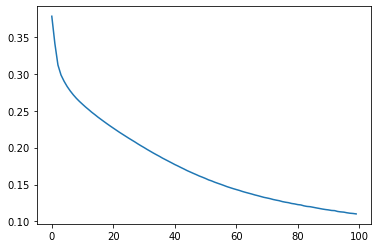

In [66]:
pl.plot(history.history['loss'])

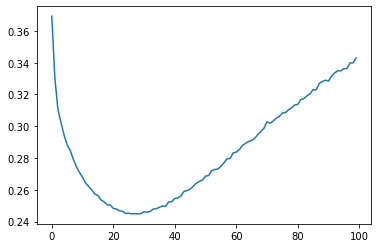

In [67]:
pl.plot(history.history['val_loss'])

In [68]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('seq2seq_eng-ger.h5')

In [69]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
  decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
  [decoder_inputs] + decoder_states_inputs,
  [decoder_outputs] + decoder_states)

In [70]:
# reverse-lookup token index to turn sequences back to characters
reverse_input_char_index = dict(
  (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
  (i, char) for char, i in target_token_index.items())

In [72]:
def decode_sequence(input_seq):
  # encode the input sequence to get the internal state vectors.
    states_value = encoder_model.predict(input_seq)
  
  # generate empty target sequence of length 1 with only the start character
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    # output sequence loop
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
          [target_seq] + states_value)

    # sample a token and add the corresponding character to the 
    # decoded sequence
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # check for the exit condition: either hitting max length
        # or predicting the 'stop' character
        if (sampled_char == '\n' or 
            len(decoded_sentence) > max_decoder_seq_length):
                stop_condition = True

        # update the target sequence (length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(10):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Where were begging children often targeted for being sold into slavery?
Decoded sentence: the Baindand Seatly Chorestor

-
Input sentence: What is the term for tranquility?
Decoded sentence: the Baindand Seatly Chorestor

-
Input sentence: Which country had successful public analog HDTV broadcasting?
Decoded sentence: the Baindand Seatly Chorestor

-
Input sentence: What does ftp stand for?
Decoded sentence: the Baindand Seatly Chorestor

-
Input sentence: Who defined mammalian as the crown group mammals?
Decoded sentence: the Baindand Seatly Chorestor

-
Input sentence: What did the PVA and KPA gain by using the tactics during the Third Phase Offensive
Decoded sentence: the Baindand Seatly Chorestor

-
Input sentence: What lake has some hotels around it?
Decoded sentence: the Baindand Seatly Chorestor

-
Input sentence: What was the title of the book written by Thomas Sowell?
Decoded sentence: the Baindand Seatly Chorestor

-
Input sentence: What is the estimated num

In [76]:
input_sentence = "How are you?"
test_sentence_tokenized = np.zeros(
  (1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
for t, char in enumerate(input_sentence):
    test_sentence_tokenized[0, t, input_token_index[char]] = 1.
print(input_sentence)
print(decode_sequence(test_sentence_tokenized))

How are you?
the Baindand Seatly Chorestor

